In [ ]:
from pathlib import Path
from dotenv import load_dotenv
import os

load_dotenv()

import sys
import os
notebook_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(notebook_dir, '..')))
volumes_dir = Path(os.getenv("VOLUME_DIR"))

import torch
from torchvision.transforms import v2

from training.experiment_config import config
from training.dataloader import get_data_loader

from tqdm import tqdm
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning, module="torchvision")
warnings.filterwarnings("ignore", category=UserWarning, module="pandas")

c:\Users\USER\envs\env_lungcancer\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\USER\envs\env_lungcancer\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may hav

In [ ]:
train = pd.read_csv(config.CSV_DIR_TRAIN)
train_ones = train[train["label"] == 1].reset_index(drop=True)
train_zeros = train[train["label"] == 0].reset_index(drop=True)

image_loader = get_data_loader(
		data_dir=config.DATADIR,
		dataset=train_ones,
		mode=config.MODE,
		workers=8,
		batch_size=config.BATCH_SIZE,
		size_px=config.SIZE_PX,
		size_mm=config.SIZE_MM,
		rotations=config.ROTATION,
		translations=config.TRANSLATION,
		)

In [3]:
train_ones.head()

,PatientID,SeriesInstanceUID,StudyDate,CoordX,CoordY,CoordZ,LesionID,AnnotationID,NoduleID,Age_at_StudyDate,Gender,label
0,104839,1.2.840.113654.2.55.30936757672243920224031101...,19990102,122.39,71.28,-220.84,1,104839_1_19990102,104839_1,55,Male,1
1,109345,1.2.840.113654.2.55.30950357318430274435755858...,19990102,57.68,-104.72,-62.51,1,109345_1_19990102,109345_1,62,Male,1
2,202952,1.3.6.1.4.1.14519.5.2.1.7009.9004.209354409551...,19990102,87.32,34.90,-80.11,1,202952_1_19990102,202952_1,56,Female,1
3,112901,1.2.840.113654.2.55.20259099074923358727086752...,20000102,-71.53,38.67,-37.77,1,112901_1_20000102,112901_1,69,Female,1
4,211570,1.3.6.1.4.1.14519.5.2.1.7009.9004.195185449252...,20000102,-56.20,-17.22,-71.04,1,211570_1_20000102,211570_1,64,Male,1


In [ ]:
for data in image_loader:
	data_id = data['ID']

	image_location = volumes_dir / "luna25_nodule_blocks" / "image" / f"{data_id}.npy"
	metadata_location = volumes_dir / "luna25_nodule_blocks" / "metadata" / f"{data_id}.npy"
	
	volume = np.load(str(image_location))
	metadata = np.load(str(metadata_location), allow_pickle=True).item()

In [4]:
image_location = volumes_dir / "luna25_nodule_blocks" / "image" / f"1_1_0.npy"
metadata_location = volumes_dir / "luna25_nodule_blocks" / "metadata" / f"1_1_0.npy"

volume = np.load(str(image_location))
metadata = np.load(str(metadata_location), allow_pickle=True).item()

In [6]:
volume.shape

(3, 3, 64, 64)

In [7]:
metadata

{'origin': array([0., 0., 0.]),
 'spacing': array([1., 1., 1.]),
 'transform': array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])}

In [15]:
label = data["label"].float()[0] #.to(device).item()
image = data["image"][0]

In [8]:
transforms = v2.Compose([
			v2.RandomAffine(degrees=(-20, 20), translate=(0.1, 0.1), scale=(0.9, 1.1)),
			v2.RandomHorizontalFlip(p=0.3),
			#v2.ToDtype(torch.float32, scale=True),
			#v2.RandomRotation(degrees=20),
			#v2.RandomResized(size=(64, 64), antialias=True),
			#v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
		])
new_image = transforms(image)

NameError: name 'image' is not defined

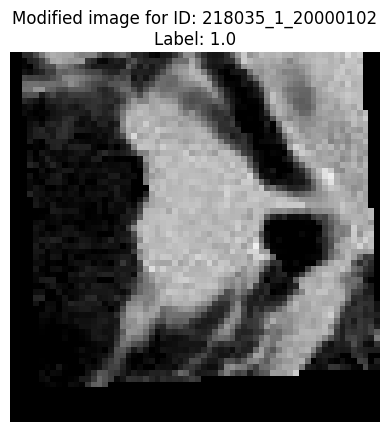

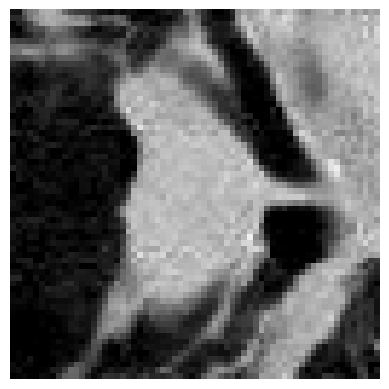

In [29]:
import matplotlib.pyplot as plt
image_np = image.permute(1, 2, 0).cpu().numpy()
img_np = new_image.permute(1, 2, 0).cpu().numpy()

plt.imshow(img_np)
plt.axis('off')
plt.title(f"Modified image for ID: {data_id}\nLabel: {label.item()}")
plt.show()

plt.imshow(image_np)
plt.axis('off')
plt.show()

In [30]:
new_image = torch.stack([new_image, new_image, new_image],dim=0)
new_image.shape

torch.Size([3, 3, 64, 64])

In [ ]:
new_AnnotationID = f"1_1_0"
new_image_location = volumes_dir / "luna25_nodule_blocks" / "image" / f"{new_AnnotationID}.npy"

new_metadata_location = volumes_dir / "luna25_nodule_blocks" / "metadata" / f"{new_AnnotationID}.npy"
dummy_metadata = {
	"origin": np.array([0.0, 0.0, 0.0]),
	"spacing": np.array([1.0, 1.0, 1.0]),
	"transform": np.eye(3)
}

# np.save(str(new_image_location), new_image.numpy())
# np.save(str(new_metadata_location), dummy_metadata)

In [10]:
train_ones = train_ones.append({
			"AnnotationID": "prueba",
			"label": 1,
		}, ignore_index=True)
train_ones.tail()

C:\Users\USER\AppData\Local\Temp\ipykernel_23288\4234912309.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_ones = train_ones.append({


,PatientID,SeriesInstanceUID,StudyDate,CoordX,CoordY,CoordZ,LesionID,AnnotationID,NoduleID,Age_at_StudyDate,Gender,label
444,207347.0,1.3.6.1.4.1.14519.5.2.1.7009.9004.323343502721...,20000102.0,76.390000,143.680000,1601.620000,1.0,207347_1_20000102,207347_1,67.0,Female,1
445,129511.0,1.2.840.113654.2.55.13038311629878726509599876...,20000102.0,49.129639,81.117416,-147.980011,1.0,129511_1_20000102,129511_1,60.0,Female,1
446,113041.0,1.2.840.113654.2.55.24320398424471135115593203...,20000102.0,-85.965645,-165.301514,-218.300003,1.0,113041_1_20000102,113041_1,56.0,Male,1
447,216940.0,1.3.6.1.4.1.14519.5.2.1.7009.9004.315936508105...,20000102.0,94.680000,58.130000,-53.850000,1.0,216940_1_20000102,216940_1,62.0,Female,1
448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,prueba,NaN,NaN,NaN,1


In [11]:
train_ones = train_ones[:-1]  # Remove the last row (the one we just added)

In [12]:
train_ones.tail()

,PatientID,SeriesInstanceUID,StudyDate,CoordX,CoordY,CoordZ,LesionID,AnnotationID,NoduleID,Age_at_StudyDate,Gender,label
443,203125.0,1.3.6.1.4.1.14519.5.2.1.7009.9004.240324207329...,19990102.0,58.770000,6.220000,-35.150000,1.0,203125_1_19990102,203125_1,67.0,Female,1
444,207347.0,1.3.6.1.4.1.14519.5.2.1.7009.9004.323343502721...,20000102.0,76.390000,143.680000,1601.620000,1.0,207347_1_20000102,207347_1,67.0,Female,1
445,129511.0,1.2.840.113654.2.55.13038311629878726509599876...,20000102.0,49.129639,81.117416,-147.980011,1.0,129511_1_20000102,129511_1,60.0,Female,1
446,113041.0,1.2.840.113654.2.55.24320398424471135115593203...,20000102.0,-85.965645,-165.301514,-218.300003,1.0,113041_1_20000102,113041_1,56.0,Male,1
447,216940.0,1.3.6.1.4.1.14519.5.2.1.7009.9004.315936508105...,20000102.0,94.680000,58.130000,-53.850000,1.0,216940_1_20000102,216940_1,62.0,Female,1


In [18]:
n_samples_to_make = (len(train_zeros) - len(train_ones))
n_samples_to_make

1794

In [ ]:
i = 2241  # Start from the next index after the last existing sample
while i <= (n_samples_to_make + 2241):
	for data in tqdm(image_loader):

		label = data["label"].float() #.to(device).item()
		image = data["image"]

		# input augmentation
		transforms = v2.Compose([
			v2.RandomHorizontalFlip(p=0.3),
			v2.RandomAffine(degrees=(-20, 20), translate=(0.1, 0.1), scale=(0.9, 1.1)),
		])
		new_image = transforms(image)
		new_image = torch.stack([new_image, new_image, new_image], dim=0)
		
		# guardar nuevo bloque de imagen
		new_AnnotationID = f"1_1_{str(i)}"
		new_image_location = volumes_dir / "luna25_nodule_blocks" / "image" / f"{new_AnnotationID}.npy"
		
		new_metadata_location = volumes_dir / "luna25_nodule_blocks" / "metadata" / f"{new_AnnotationID}.npy"
		dummy_metadata = {
			"origin": np.array([0.0, 0.0, 0.0]),
			"spacing": np.array([1.0, 1.0, 1.0]),
			"transform": np.eye(3)
		}
		
		np.save(str(new_image_location), new_image.numpy())
		np.save(str(new_metadata_location), dummy_metadata)

		train_ones = train_ones.concat(
			train_ones,
			{
				"AnnotationID": new_AnnotationID,
				"label": label.item(),
			},
			ignore_index=True)

		i+=1

	print(f"""Added {i} new images to the dataset.
	   Currently, there are {len(train_ones)} positive samples and {len(train_zeros)} negative samples.""")

  0%|          | 0/448 [00:00<?, ?it/s]C:\Users\USER\AppData\Local\Temp\ipykernel_23288\1140079577.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_ones = train_ones.append({
  0%|          | 1/448 [00:53<6:39:24, 53.61s/it]C:\Users\USER\AppData\Local\Temp\ipykernel_23288\1140079577.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_ones = train_ones.append({
C:\Users\USER\AppData\Local\Temp\ipykernel_23288\1140079577.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_ones = train_ones.append({
  1%|          | 3/448 [00:53<1:43:22, 13.94s/it]C:\Users\USER\AppData\Local\Temp\ipykernel_23288\1140079577.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

Added 2689 new images to the dataset.
	   Currently, there are 3136 positive samples and 4482 negative samples.


  0%|          | 0/448 [00:00<?, ?it/s]C:\Users\USER\AppData\Local\Temp\ipykernel_23288\1140079577.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_ones = train_ones.append({
  0%|          | 1/448 [00:58<7:12:59, 58.12s/it]C:\Users\USER\AppData\Local\Temp\ipykernel_23288\1140079577.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_ones = train_ones.append({
C:\Users\USER\AppData\Local\Temp\ipykernel_23288\1140079577.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_ones = train_ones.append({
  1%|          | 3/448 [00:58<1:52:03, 15.11s/it]C:\Users\USER\AppData\Local\Temp\ipykernel_23288\1140079577.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

Added 3137 new images to the dataset.
	   Currently, there are 3584 positive samples and 4482 negative samples.


  0%|          | 0/448 [00:00<?, ?it/s]C:\Users\USER\AppData\Local\Temp\ipykernel_23288\1140079577.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_ones = train_ones.append({
  0%|          | 1/448 [00:56<6:59:18, 56.28s/it]C:\Users\USER\AppData\Local\Temp\ipykernel_23288\1140079577.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_ones = train_ones.append({
C:\Users\USER\AppData\Local\Temp\ipykernel_23288\1140079577.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_ones = train_ones.append({
  1%|          | 3/448 [00:56<1:48:31, 14.63s/it]C:\Users\USER\AppData\Local\Temp\ipykernel_23288\1140079577.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

Added 3585 new images to the dataset.
	   Currently, there are 4032 positive samples and 4482 negative samples.


  0%|          | 0/448 [00:00<?, ?it/s]C:\Users\USER\AppData\Local\Temp\ipykernel_23288\1140079577.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_ones = train_ones.append({
  0%|          | 1/448 [00:56<7:00:12, 56.40s/it]C:\Users\USER\AppData\Local\Temp\ipykernel_23288\1140079577.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_ones = train_ones.append({
C:\Users\USER\AppData\Local\Temp\ipykernel_23288\1140079577.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_ones = train_ones.append({
  1%|          | 3/448 [00:56<1:48:45, 14.67s/it]C:\Users\USER\AppData\Local\Temp\ipykernel_23288\1140079577.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

Added 4033 new images to the dataset.
	   Currently, there are 4480 positive samples and 4482 negative samples.


  0%|          | 0/448 [00:00<?, ?it/s]C:\Users\USER\AppData\Local\Temp\ipykernel_23288\1140079577.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_ones = train_ones.append({
  0%|          | 1/448 [00:58<7:12:13, 58.02s/it]C:\Users\USER\AppData\Local\Temp\ipykernel_23288\1140079577.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_ones = train_ones.append({
C:\Users\USER\AppData\Local\Temp\ipykernel_23288\1140079577.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_ones = train_ones.append({
  1%|          | 3/448 [00:58<1:51:54, 15.09s/it]C:\Users\USER\AppData\Local\Temp\ipykernel_23288\1140079577.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

Added 4481 new images to the dataset.
	   Currently, there are 4928 positive samples and 4482 negative samples.


In [23]:
4482 - 4928

-446

In [25]:
train_new = pd.concat([train_zeros, train_ones], ignore_index=True)
train_new.label.value_counts()

1.0    4928
0.0    4482
Name: label, dtype: int64

In [26]:
train_new = train_new[:-446]
train_new.label.value_counts()

0.0    4482
1.0    4482
Name: label, dtype: int64

In [27]:
#train_new = pd.concat([train_ones, train_zeros], ignore_index=True)

new_csv_location = volumes_dir / "train_augmented.csv"
if not new_csv_location.parent.exists():
	new_csv_location.parent.mkdir(parents=True)
train_new.to_csv(str(new_csv_location), index=False)